In [31]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pylab as plt
import cv2
from matplotlib import image
import os
import numpy as np
from scipy import ndimage
from scipy.ndimage import morphology
import mach_functions


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
images = dict()

In [64]:
images['bgrimage'] = cv2.imread("./TestImages/80ydata.png")

In [65]:
images['cleanImage'] = mach_functions.cleanImage(images['bgrimage'],cellThres=120)

In [66]:
images['grayImage'] = mach_functions.invertGrayImage(images['cleanImage'])

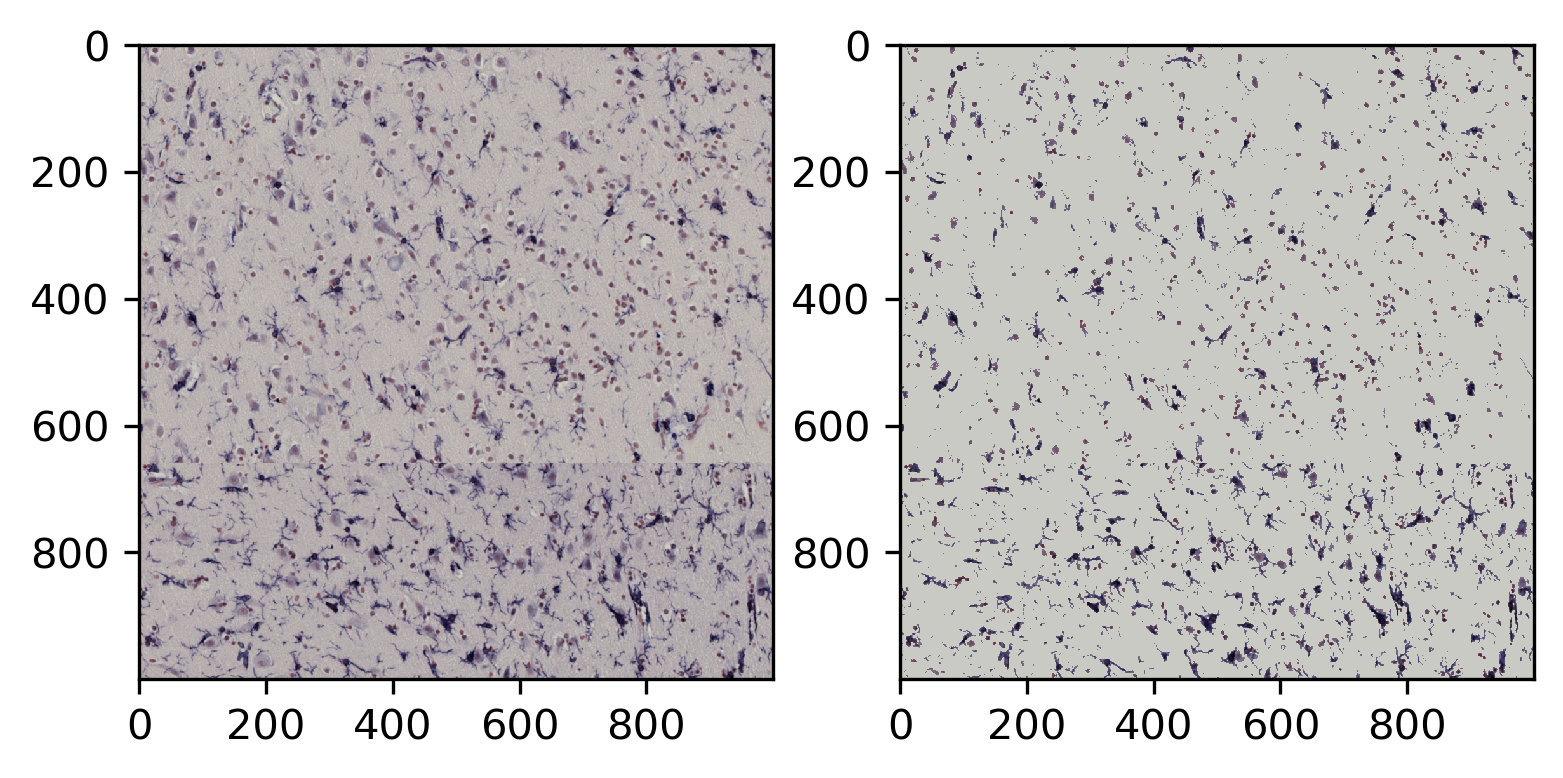

In [55]:
plt.figure(dpi=300)

plt.subplot(1,2,1)
plt.imshow(images['bgrimage'])

plt.subplot(1,2,2)
plt.imshow(images['cleanImage'])


In [41]:
yamlFile = "Params.yaml"
Params = mach_functions.load_yaml(yamlFile)
Filters = mach_functions.readInfilters(Params)

In [16]:
#smallImages = mach_functions.divde_big_image(image['grayImage'])
#smallColorImage = mach_functions.divde_big_image(image['rgbImage'])

In [60]:
def runFiltering(image,Params,Filters):
    """
    Read in the parameters in the yamlFile and run the hierarchical filtering 
    """

    #directory to store the results
    detectedCells = dict()

    if Params['PenaltyFilterOption'] == 1:
        print ("using the 'rodp' as penalty filter for rod cell detection")
        penaltyFilter = Filters['PenaltyFilters']['rodp']
        rodSNR = Params['rodSNR'][0]
    else:
        print ("using the 'rrodp' as penalty filter for rod cell detection")
        penaltyFilter = Filters['PenaltyFilters']['rrodp']
        rodSNR = Params['rodSNR'][1]
    
    penaltyFilter = Filters['PenaltyFilters']['newrodp']
    rodSNR=0.78
    # detect rod and remove the cells in the test image
    print ("Detecting the rod cells ---")
    detectedCells['rod'],crPlanes = mach_functions.giveRod(image,Filters['NormalFilters']['newrod'],penaltyFilter,\
                                                    snrthres=rodSNR,fragRodRefine=True,\
                                                        somaFilter=Filters['NormalFilters']['amoe'],
                                                        somathres=0.33,areaRefine=True,
                                                        )
    newtestImage = mach_functions.removeDetectedCells(image,detectedCells['rod'],bgmthres=0.4)

    # detect ram and hyp
    print ("Detecting the ram/hyp cells ---")
    detectedCells['ram'], detectedCells['hyp'] = mach_functions.giveRamHyp(newtestImage,\
                                                 Filters['PartialFilters']['ramp'],\
                                                 Filters['PartialFilters']['hypp'],\
                                                 Params['rampThres'],\
                                                 Params['hyppThres'] )

    newtestImage = mach_functions.removeDetectedCells(newtestImage,detectedCells['ram'],bgmthres=0.4)
    newtestImage = mach_functions.removeDetectedCells(newtestImage,detectedCells['hyp'],bgmthres=0.4)

    # detect amoe and dys
    print ("Detecting the amoe/dys cells ---")
    detectedCells['amoe'],detectedCells['dys'] = mach_functions.giveAmoeDys(newtestImage,\
                                                                Filters['NormalFilters']['amoe'],\
                                                                Params['amoeThres'],\
                                                                Params['areaThres'])
    


    return detectedCells

In [67]:
#allresults = []
#for i,j in enumerate(smallImages):
#    print (f"Small Image ID: {i+1}")
results = runFiltering(images['grayImage'],Params,Filters)
#allresults.append(tempresults)


using the 'rrodp' as penalty filter for rod cell detection
Detecting the rod cells ---
Detecting the ram/hyp cells ---
Detecting the amoe/dys cells ---


In [68]:
redresults = mach_functions.pasteImage(images['bgrimage'],results['rod'],'red')

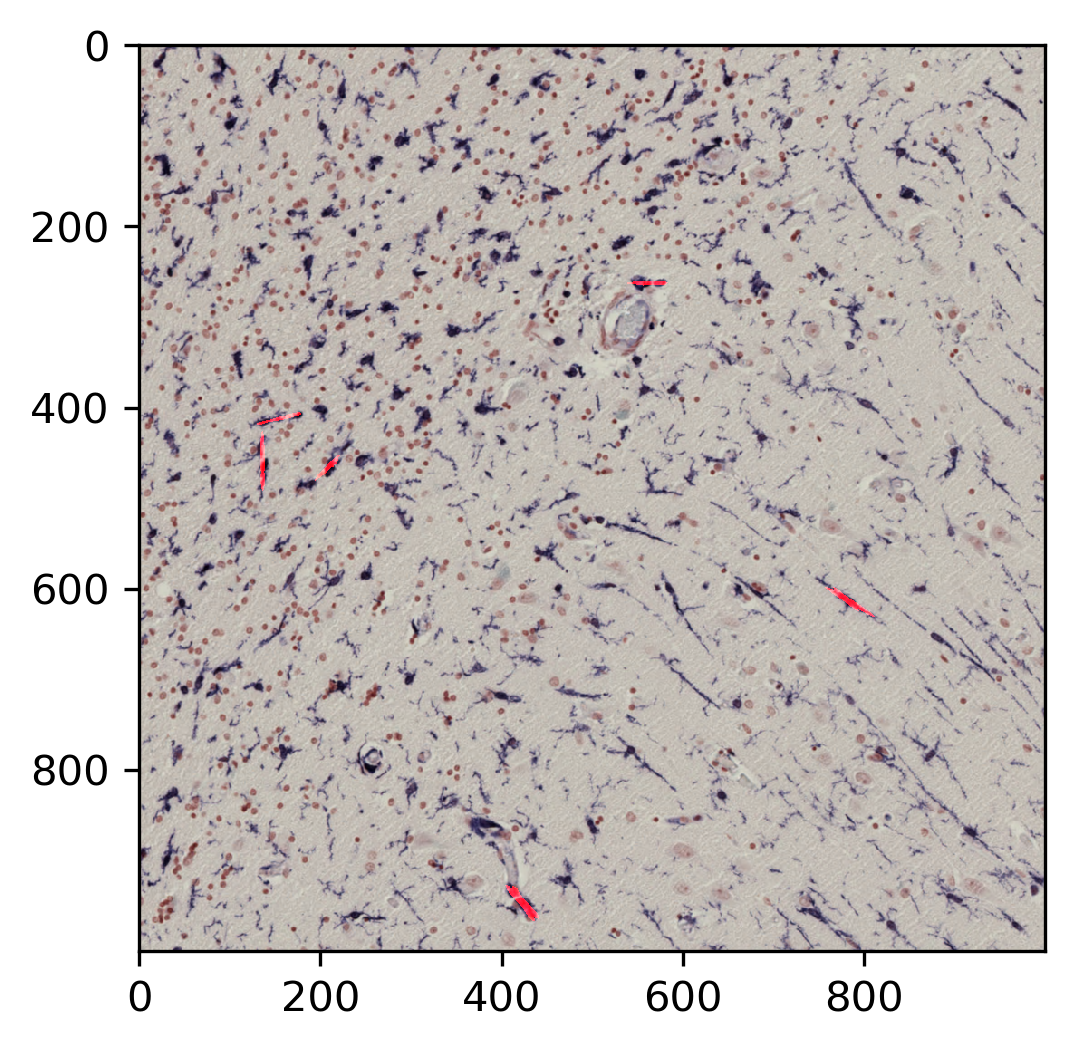

In [69]:
plt.figure(dpi=300)
plt.imshow(redresults)